In [1]:

#import packages

import numpy as np
import pandas as pd 
import duckdb
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# Set the font globally to Helvetica to allow editable text
plt.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['pdf.fonttype'] = 42
from rdkit.Chem import AllChem, MolFromSmiles
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw


#initialize mapply
import mapply
mapply.init(
    n_workers=-1,
    progressbar=True,
)

In [2]:
#download the data
DOWNLOAD = False
if DOWNLOAD:
    competition_name = "leash-BELKA" 
    download_path = "../data"
    
    #create new directory
    os.makedirs(download_path, exist_ok=True)
    
    # Download the data
    os.system(f"kaggle competitions download -c {competition_name} -p {download_path}")
    
    # Unzip 
    os.system(f"unzip {download_path}/*.zip -d {download_path}")

In [3]:
#set the path to the data
train_path = "../data/train.parquet"
test_path = "../data/test.parquet"

#extract all the building blocks from the data
con = duckdb.connect()
all_building_blocks_df = con.query(f"""(SELECT * FROM (
    SELECT distinct buildingblock1_smiles as smile, 'buildingblock1' as group, 'test' as split, protein_name, 2 as binds  FROM parquet_scan('{test_path}')
    UNION
    SELECT distinct buildingblock1_smiles as smile, 'buildingblock1' as group, 'train' as split, protein_name, binds FROM parquet_scan('{train_path}')
    UNION
    SELECT distinct buildingblock2_smiles as smile, 'buildingblock2' as group, 'test' as split, protein_name, 2 as binds  FROM parquet_scan('{test_path}')
    UNION
    SELECT distinct buildingblock2_smiles as smile, 'buildingblock2' as group, 'train' as split, protein_name, binds FROM parquet_scan('{train_path}')
    UNION
    SELECT distinct buildingblock3_smiles as smile, 'buildingblock3' as group, 'test' as split, protein_name, 2 as binds  FROM parquet_scan('{test_path}')
    UNION
    SELECT distinct buildingblock3_smiles as smile, 'buildingblock3' as group, 'train' as split, protein_name, binds FROM parquet_scan('{train_path}')
    ) as t)""").df()
con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
#count the number of building block 1, 2 and 3 in train split and test split
# Group by protein_name and building_block, and count the occurrences
count_df = all_building_blocks_df.groupby(['protein_name', 'group','split']).size().reset_index(name='count')
count_df

,protein_name,group,split,count
0,BRD4,buildingblock1,test,341
1,BRD4,buildingblock1,train,542
2,BRD4,buildingblock2,test,1140
3,BRD4,buildingblock2,train,1386
4,BRD4,buildingblock3,test,1389
5,BRD4,buildingblock3,train,1726
6,HSA,buildingblock1,test,341
7,HSA,buildingblock1,train,542
8,HSA,buildingblock2,test,1140
9,HSA,buildingblock2,train,1385


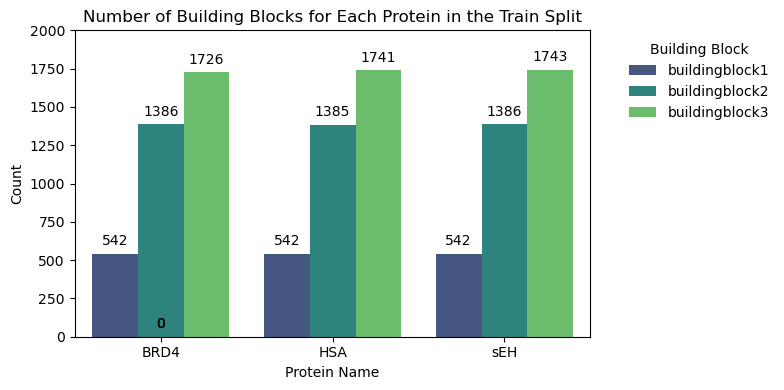

In [5]:
#plot the number of building block 1, 2 and 3 in train split and test split
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=count_df[count_df["split"]=="train"], x='protein_name', y='count', hue='group', palette='viridis')

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),  # 9 points vertical offset
                textcoords = 'offset points')

plt.title('Number of Building Blocks for Each Protein in the Train Split')
plt.xlabel('Protein Name')
plt.ylabel('Count')
plt.legend(title='Building Block', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.ylim(0,2000)
plt.tight_layout()
plt.show()

In [6]:
train_smiles_bb_sEH = set(all_building_blocks_df[ (all_building_blocks_df['split'] == 'train')  & (all_building_blocks_df['protein_name'] == 'sEH')]['smile'])
test_smiles_bb_sEH = set(all_building_blocks_df[  (all_building_blocks_df['split'] == 'test')  & (all_building_blocks_df['protein_name'] == 'sEH')]['smile'])

train_smiles_bb_HSA = set(all_building_blocks_df[ (all_building_blocks_df['split'] == 'train')  & (all_building_blocks_df['protein_name'] == 'HSA')]['smile'])
test_smiles_bb_HSA = set(all_building_blocks_df[  (all_building_blocks_df['split'] == 'test')  & (all_building_blocks_df['protein_name'] == 'HSA')]['smile'])

train_smiles_bb_BRD4 = set(all_building_blocks_df[ (all_building_blocks_df['split'] == 'train')  & (all_building_blocks_df['protein_name'] == 'BRD4')]['smile'])
test_smiles_bb_BRD4 = set(all_building_blocks_df[  (all_building_blocks_df['split'] == 'test')  & (all_building_blocks_df['protein_name'] == 'BRD4')]['smile'])

Text(0.5, 0.98, 'New building blocks in the test set')

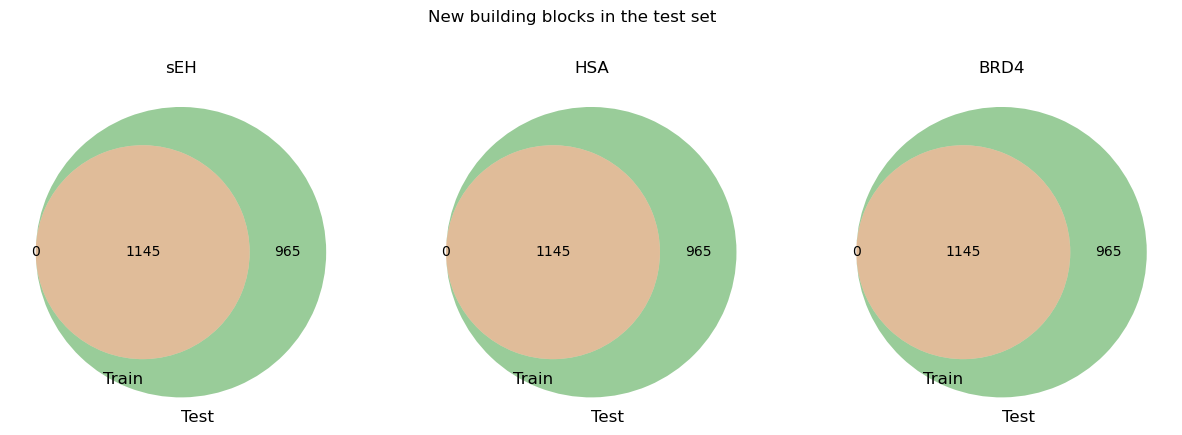

In [7]:
fig, ax  = plt.subplots(1,3, figsize=(15,5))
ax[0].set_title("sEH")
ax[1].set_title("HSA")
ax[2].set_title("BRD4")

venn2([train_smiles_bb_sEH, test_smiles_bb_sEH], set_labels = ('Train', 'Test'), ax=ax[0])
venn2([train_smiles_bb_HSA, test_smiles_bb_HSA], set_labels = ('Train', 'Test'), ax=ax[1])
venn2([train_smiles_bb_BRD4, test_smiles_bb_BRD4], set_labels = ('Train', 'Test'), ax=ax[2])
fig.suptitle('New building blocks in the test set')

In [8]:
new_bbs_in_test_list_sEH = sorted(list(test_smiles_bb_sEH - train_smiles_bb_sEH ))
new_bbs_in_test_list_HSA = sorted(list(test_smiles_bb_HSA - train_smiles_bb_HSA ))
new_bbs_in_test_list_BRD4 = sorted(list(test_smiles_bb_BRD4 - train_smiles_bb_BRD4 ))

In [10]:
#converts a SMILES string to a RDKit molecule object, then checks if it has a triazine substructure match.
def check_for_triazine(x):
    triazine = MolFromSmiles('C1=NC=NC=N1')
    check = MolFromSmiles(x).HasSubstructMatch(triazine)
    return check



In [11]:
def check_building_blocks(row):
    # Check each building block against the list
    exists = any(block in new_bb_list for block in [row['buildingblock1_smiles'], row['buildingblock2_smiles'], row['buildingblock3_smiles']])
    # Return 1 if any building block exists, else 0
    return int(exists)

In [12]:

protein_names = ['sEH', 'HSA', 'BRD4']
new_bb_lists = [new_bbs_in_test_list_sEH, new_bbs_in_test_list_HSA, new_bbs_in_test_list_BRD4]
for protein_name,new_bb_list in zip(protein_names,new_bb_lists):
    con = duckdb.connect()

    df_test = con.query(f"""(SELECT *
                        FROM parquet_scan('{test_path}')
                        WHERE protein_name = '{protein_name}'
                        ORDER BY random()
                        )""").df()

    con.close()
    # Function to check if any building block exists in new_bbs_in_test_list_sEH


    # Apply the function to each row in df_test
    df_test['new_bbs'] = df_test.mapply(check_building_blocks, axis=1)
    df_test['triazine'] = df_test['molecule_smiles'].mapply(check_for_triazine)
    # Display the updated DataFrame
   
    new_bbs = df_test[['id','new_bbs','triazine']]
    new_bbs.head()
    
    #save new building blocks for further evaluation
    new_bbs.to_csv(f"../data/targets/{protein_name}/evaluation/{protein_name}_new_bbs.csv", index=False)

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

In [13]:
#read the new building blocks list
bbs_sEH = pd.read_csv("../data/targets/sEH/evaluation/sEH_new_bbs.csv")
bbs_HSA = pd.read_csv("../data/targets/HSA/evaluation/HSA_new_bbs.csv")
bbs_BRD4 = pd.read_csv("../data/targets/BRD4/evaluation/BRD4_new_bbs.csv")

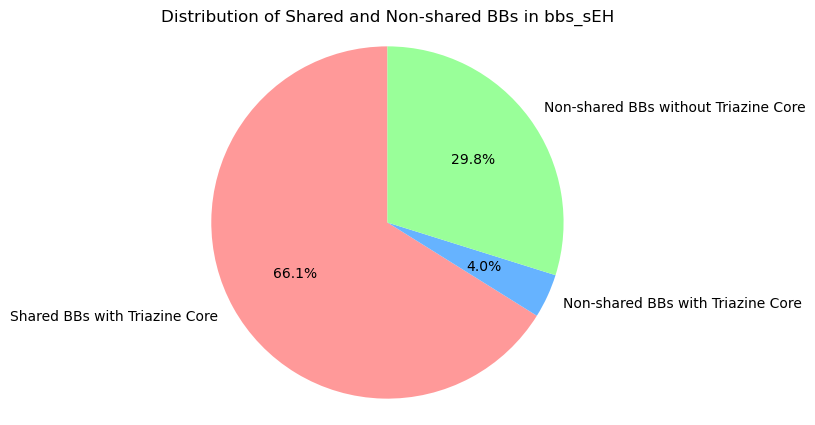

In [14]:


# Aggregate the data
bbs_sEH_with_triazine = bbs_sEH[bbs_sEH['triazine'] == True]
bbs_sEH_without_triazine = bbs_sEH[bbs_sEH['triazine'] == False]

# Count the occurrences for each category
count_shared_with_triazine = bbs_sEH_with_triazine[bbs_sEH_with_triazine['new_bbs'] == 0].shape[0]
count_non_shared_with_triazine = bbs_sEH_with_triazine[bbs_sEH_with_triazine['new_bbs'] == 1].shape[0]
count_non_shared_without_triazine = bbs_sEH_without_triazine[bbs_sEH_without_triazine['new_bbs'] == 1].shape[0]

# Prepare the data for the pie chart
labels = ['Shared BBs with Triazine Core', 'Non-shared BBs with Triazine Core', 'Non-shared BBs without Triazine Core']
sizes = [count_shared_with_triazine, count_non_shared_with_triazine, count_non_shared_without_triazine]
colors = ['#ff9999', '#66b3ff', '#99ff99']

# Create the pie chart
fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Shared and Non-shared BBs in bbs_sEH')
plt.show()

In [26]:

#create a df of trainset from databases
con = duckdb.connect()
df_train = con.query(f"""(SELECT protein_name,binds
                    FROM parquet_scan('{train_path}')
                    ORDER BY random()
                    )""").df()

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [27]:
count_df_train = df_train.groupby(['protein_name', 'binds']).size().reset_index(name='count')
# Calculate the total count for each protein_name
total_counts = count_df_train.groupby('protein_name')['count'].transform('sum')

# Calculate the percentage for each binds category within each protein_name group
count_df_train['percentage'] = count_df_train['count'] / total_counts * 100
count_df_train

,protein_name,binds,count,percentage
0,BRD4,0,97958646,99.535679
1,BRD4,1,456964,0.464321
2,HSA,0,98007200,99.585015
3,HSA,1,408410,0.414985
4,sEH,0,97691078,99.263804
5,sEH,1,724532,0.736196


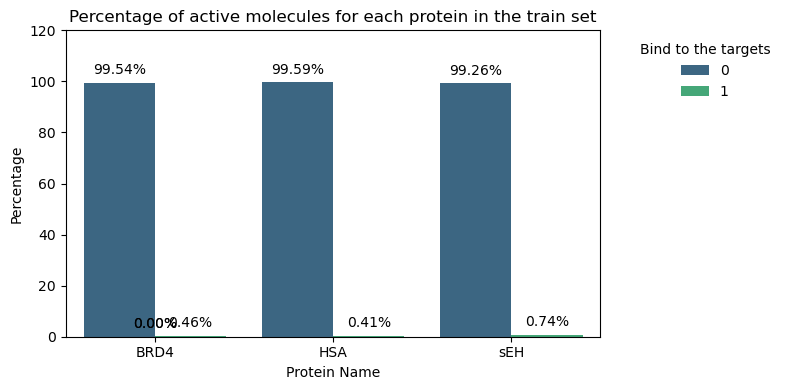

In [34]:
# Plot the number of building blocks as percentages
plt.figure(figsize=(8, 4))
ax = sns.barplot(data=count_df_train, x='protein_name', y='percentage', hue='binds', palette='viridis')

# Add percentage numbers on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 9),  # 9 points vertical offset
                textcoords='offset points')

plt.title('Percentage of active molecules for each protein in the train set')
plt.xlabel('Protein Name')
plt.ylabel('Percentage')
plt.legend(title='Bind to the targets', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.ylim(0,120)
plt.tight_layout()
plt.show()